**Group Members**
1. **Trilokinath Modi**
2. **Linus Aronsson**
3. **Akshita Pingle**

**Assignment 2 Task 1**

# Basic Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from collections import Counter
import numpy as np
from spacy.lang.en import English
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator

nlp = English()

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
colWidth = pd.get_option('display.max_colwidth')

# Class and function definitions

In [ ]:
class Corpus:
    def __init__(self, filePath, encoding, maxTokens):
        self.bagOfWords = Counter()
        self.listOfWords = ["removeMe"]  # So that the list is not empty
        self.wordInDocIndex = np.zeros(1, dtype=int)  # So that array is not empty
        self.docLen = list()
        self.numDocs = 0
        docNumber = 0
        numActualToken = 0
        fileHandler = open(filePath, encoding=encoding)
        with fileHandler:
            for doc in fileHandler:
                self.numDocs += 1
                tokens = doc.lower().split()
                numActualToken += len(tokens)
                numTokenTemp = 0
                for iToken in tokens:
                    if not nlp.vocab[iToken].is_stop and iToken not in ['.', '&', '...', '-', ';', '/', '!', ',', '(',
                                                                        ')', "'", '"', ':', "?",
                                                                        '....'] and not iToken.isdigit():
                        self.bagOfWords[iToken] += 1
                        self.listOfWords = self.listOfWords + [iToken]
                        numTokenTemp += 1
                self.docLen.append(numTokenTemp)
                tempArray = docNumber * np.ones(numTokenTemp, dtype=int)
                self.wordInDocIndex = np.concatenate((self.wordInDocIndex, tempArray), axis=None)
                docNumber += 1
                if numActualToken >= maxTokens + 1:
                    self.listOfWords.pop(0)  # Removed "removeMe"
                    self.wordInDocIndex = np.delete(self.wordInDocIndex, 0)
                    break
        fileHandler.close()

    def most_common_word(self, numOfMostCommonWords):
        self.corpusMostCommonWords = Counter(self.bagOfWords).most_common(numOfMostCommonWords)


class IntegerVocabulary:
    def __init__(self, mostCommonWords, maxVocabSize):
        self.integerVocab = dict()  # Changed from list to dict - See assignment 1
        wordCode = 0
        for iWord in range(maxVocabSize):
            self.integerVocab[mostCommonWords[iWord][0]] = wordCode
            wordCode += 1


In [ ]:
def estimateDocTopicProb(docId):
    numerator = docTopicFreq[docId] + topicParameter
    denominator = books.docLen[docId] - 1 + numTopics * topicParameter
    return numerator / denominator


def estimateTopicWordProb(wordIndex, prevWordIndex):
    numerator = bigramTopicFreq[wordIndex, prevWordIndex] + dirParameter
    sumWordsinToken = np.sum(wordTopicFreq, axis=0)
    denominator = sumWordsinToken + numUniqueWords * dirParameter
    return numerator / denominator


def estimateTopicWordProbUnPairedWords(wordIndex):  # The first words don't have preceeding word so this function is
    # picked from task 1 of this assignment.
    numerator = wordTopicFreq[wordIndex] + dirParameter
    sumWordsinToken = wordTopicFreq.sum(axis=0)
    denominator = sumWordsinToken + numUniqueWords * dirParameter  # Need to check if should be commented or included.
    return numerator / denominator

**Variable Defifnition**

In [ ]:
filePath = "/content/drive/My Drive/MLNLP/Assignment2/books.txt"
fileEncoding = "ISO-8859-1"

In [ ]:
maxGibbsIterations = 200
maxTokens = 100000
desiredWordsToBePrinted = 20

In [ ]:
books = Corpus(filePath, fileEncoding, maxTokens)
maxTokens = len(books.listOfWords)
numUniqueWords = len(books.bagOfWords)
numDocs = len(books.docLen)

maxVocabSize = numUniqueWords
numOfMostCommonWords = maxVocabSize  # Not considering padding and out-of-vocabulary - See assignment 1
books.most_common_word(numOfMostCommonWords)
booksIV = IntegerVocabulary(books.corpusMostCommonWords, maxVocabSize)

In [ ]:
documentTopicsDF = pd.DataFrame()
figureNum = 0
numTopicsList = [10, 50]
parameterList = [(0.1, 0.1), (0.01, 0.01)]

wordTopicResultsT1 = list()
sumWordsinTokenResultsT1 = list()

# Execution loop

In [ ]:
iCase = 0
for iTopicList in range(len(numTopicsList)):
    for iParameterList in range(len(parameterList)):
        print(iCase, end=" ")
        numTopics = numTopicsList[iTopicList]
        dirParameter = parameterList[iParameterList][0]
        topicParameter = parameterList[iParameterList][1]

        wordTopicResultsT1.append(list())
        sumWordsinTokenResultsT1.append(np.zeros(numTopics))

        wordTopic = np.random.randint(0, numTopics, maxTokens)
        wordTopicFreq = np.zeros((numUniqueWords, numTopics), dtype=int)

        docId = np.arange(0, numDocs, 1)
        docTopicFreq = np.zeros((numDocs, numTopics), dtype=int)

        # Random initialization matrix updates
        jDocId = 0
        for iNumber, iWord in enumerate(books.listOfWords):
            wordIdentity = booksIV.integerVocab[iWord]
            wordTopicFreq[wordIdentity, wordTopic[iNumber]] += 1
            jDocId = books.wordInDocIndex[iNumber]
            docTopicFreq[jDocId, wordTopic[iNumber]] += 1

        iGibbs = 0
        while iGibbs < maxGibbsIterations:
            iGibbs += 1
            iDocId = 0
            for iNumber, iWord in enumerate(books.listOfWords):
                topicNumber = wordTopic[iNumber]
                wordIdentity = booksIV.integerVocab[iWord]
                wordTopicFreq[wordIdentity, topicNumber] -= 1
                iDocId = books.wordInDocIndex[iNumber]
                docTopicFreq[iDocId, topicNumber] -= 1
                docTopicProb = estimateDocTopicProb(iDocId)
                wordTopicProb = estimateTopicWordProbUnPairedWords(
                    wordIdentity)  # Notice we have passed the integer index
                probWordInToken = np.multiply(docTopicProb, wordTopicProb)
                selectedTopic = np.random.multinomial(1, probWordInToken / probWordInToken.sum()).argmax()
                wordTopicFreq[booksIV.integerVocab[iWord], selectedTopic] += 1
                docTopicFreq[iDocId, selectedTopic] += 1
                wordTopic[iNumber] = selectedTopic

        wordTopicResultsT1[iCase] = wordTopic
        sumWordsinTokenResultsT1[iCase] = wordTopicFreq.sum(axis=0)
        iCase += 1


0 1 2 3 

# Results

The next cell contains all the infomartion required to analyse results and draw conclusions. The cell contains 1 figure and 2 tables each for one of the 4 cases. The figure represents the fraction of words present in the topic as compared to total number of words considered for execution. The two tables represents words in each topic and words in the dominant topic of each document. Both the tables are trimmed to display 5 top topics and 15 documents respectively.

In general, the abstract format of output is figure, top 5 topics table and dominant topic in document table.

The table with top 5 topics portrays words that settled in topic by raw count, relative count and a mixture of raw and relative count. Raw count implies the words that are dominant within the topic, relative implies the words that are unique within corpus but ended under the highlighted topic and "relraw" implies the words first sorted based on raw count and then top 20 words were picked which were sorted by their relative count in the corpus. 

The table related to documents and dominant topic in the document goes through every document and looks for the topic that is dominant within the document and prints how much percentage of document exists in the topic and some of the words in this intersection. 

The observations are explained after printing all the outputs below.

Case 1, α = 0.10, β = 0.10, K = 10




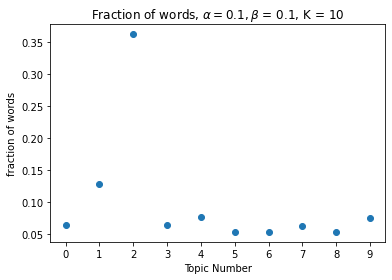

0            1              2           3   \
Topic 3 Raw           sam      history           work      gibbon   
        Rel       memphis          bbq       surround    analyzes   
        RelRaw        sam       gibbon      guralnick       cooke   
Topic 9 Raw        family     daughter          story         man   
        Rel        season  meaningless  functionality  deservedly   
        RelRaw       alex     daughter           soon      father   
Topic 4 Raw           war        world       american       power   
        Rel           bin        laden      strategic     stinger   
        RelRaw     growth        media       military  government   
Topic 1 Raw          book     students           good        read   
        Rel     exercises       astral  specificities  explosives   
        RelRaw   students     examples           text         dr.   
Topic 2 Raw          book         read           like        life   
        Rel     mr.magnus   projection           adds        feel   
        RelRaw      novel   characters           love     writing   

                            4          5           6              7   \
Topic 3 Raw          guralnick      women       cooke        version   
        Rel                ali  honorably  discharged         scores   
        RelRaw       biography    johnson       peter       official   
Topic 9 Raw             father      years        life         mother   
        Rel      sensibilities      anita      coelho         cavour   
        RelRaw           house    mystery     brother         friend   
Topic 4 Raw             people    america  government        country   
        Rel           missiles    mohamed   unnerving  egyptian-born   
        RelRaw             war   american     america      political   
Topic 1 Raw              great        use       books           time   
        Rel     conceptualized        gtr        lied      photoshop   
        RelRaw         chapter      ideas      review            use   
Topic 2 Raw              story    reading        time          great   
        Rel              enter      realm      unlike         bogged   
        RelRaw            like    reading      author         little   

                            8              9                 10        11  \
Topic 3 Raw             events        opinion             death       men   
        Rel                ceo  fragmentation              blow    strike   
        RelRaw             men        content        commentary   opinion   
Topic 9 Raw             friend           home             house     young   
        Rel           inducted      brazilian             2002.  veronika   
        RelRaw          mother           home            family       man   
Topic 4 Raw                mr.            new         political       job   
        Rel     middle-eastern    afghanistan        terrorists      inc.   
        RelRaw           power        country               add   process   
Topic 1 Raw                new            way             ideas  examples   
        Rel           channels          kelby  well-established   concise   
        RelRaw            easy           know              good       new   
Topic 2 Raw                way         people              good    author   
        Rel               echo         geared               fan        ed   
        RelRaw            read           life             story     found   

                       12             13          14            15  \
Topic 3 Raw     biography        johnson  commentary     religious   
        Rel         camps  competiveness     japense    succesfull   
        RelRaw  religious        version      events         death   
Topic 9 Raw       mystery           alex        best          long   
        Rel       twelfth      attempted   overdosed       vilette   
        RelRaw      young         series        long         women   
Topic 4 Raw      military           work  

,Document Number,Dominant Topic,Percentage,Words In Dominant Topic
530,530,1.0,1.0,"[summary, provide, comprehensive, review, traditional, nutrition, provides, information, traditional, supplements, discussion, current, nutritiona..."
29,29,2.0,1.0,"[great, way, save, space, wonderful, books, love, hunting, find, paperback, great, nora, roberts, stories]"
540,540,2.0,1.0,"[excellent, book, informative, interesting, books, read, life]"
123,123,1.0,1.0,"[book, lots, great, pictures, cafes, restaurants, title, bought, ideas, work, loved, flipping, book, brain, needs, new, ideas, looking, architects..."
23,23,2.0,1.0,"[nora, garden, trilogy, great, best, characters, life-like, actually, feel, like, story, phenomenal, author, come, thoroughly, enjoyed, highly, re..."
290,290,2.0,1.0,"[fast, pace, times, intense, kept, interest, entire, book]"
113,113,2.0,1.0,"[far, favorite, version, classic, story, authentic, true, spirit, book, cast, direction, excellent, setting, gorgeous, film, delight, children, ad..."
128,128,2.0,1.0,"[love, book, keith, awsome, motivational, speaker, finished, reading, book, fast, help, needing, new, start, life, person, holding, thank, keith, ..."
149,149,2.0,1.0,"[lot, good, factual, information, written, readable, fashion, want, family, read, book, lives, san, francisco, bay, area, read, ordered, copy, gift]"
254,254,2.0,1.0,"[book, insightful, life, changing, book, looking, finally, found, book, helped, understand, feel, feel, felt, entire, life, normal, life, saving, ..."





Case 2, α = 0.01, β = 0.01, K = 10




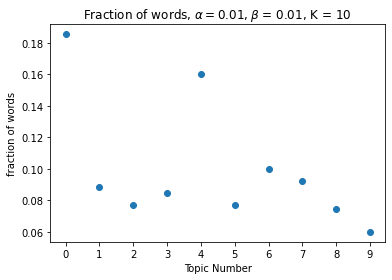

0           1           2          3             4   \
Topic 1 Raw          work     history      school     people      american   
        Rel     terrorism         bin    surround   missiles     honorably   
        RelRaw     gibbon   knowledge       state       line       country   
Topic 7 Raw          book       great        work        way        people   
        Rel            ed       hearn       laden  strategic           ali   
        RelRaw  religious       study       ideas       case      research   
Topic 6 Raw          book         sam        time       like          read   
        Rel           ins        outs     diehard   baseball  instrumental   
        RelRaw        sam         bob     version    chapter         title   
Topic 4 Raw          book        read        like    reading         books   
        Rel        astral  projection        adds    entries       journal   
        RelRaw     future     writing  characters    written           end   
Topic 0 Raw          book       books        read    reading          good   
        Rel       started   mr.magnus         fun     unlike        bogged   
        RelRaw     things      family       books       know         found   

                         5              6           7               8   \
Topic 1 Raw            john            war         use          gibbon   
        Rel     afghanistan      knowledge      scores  multi-national   
        RelRaw       nature     government    american            high   
Topic 7 Raw           years          ideas   excellent          reader   
        Rel         mohamed      unnerving      valued        paradigm   
        RelRaw     examples      excellent        work           great   
Topic 6 Raw          little        chapter        real          author   
        Rel           handy        marches       dance           tunes   
        RelRaw         kind           says         bad           worth   
Topic 4 Raw         writing          story  characters         written   
        Rel           realm  specificities       lodge         avonlea   
        RelRaw       reader          found        read         reading   
Topic 0 Raw            life           like         way             new   
        Rel            echo           anne        girl           scoop   
        RelRaw          new        reading   recommend             way   

                       9          10           11         12  \
Topic 1 Raw     knowledge       year      country       line   
        Rel         model        ceo        cells   measures   
        RelRaw     school       john   historical       year   
Topic 7 Raw       written      world         case        end   
        Rel     functions  terrorist       profit  corporate   
        RelRaw        end      years  interesting     reader   
Topic 6 Raw         worth       good          bob        bad   
        Rel          folk   preserve      memphis     street   
        RelRaw       real      point       little       time   
Topic 4 Raw         great     author        found       time   
        Rel          asna  dominated     men.well  reading.a   
        RelRaw       love     author         like     little   
Topic 0 Raw        things     people         know      great   
        Rel        locker     season        stars     helped   
        RelRaw       book       good         life     people   

                              13           14           15             16  \
Topic 1 Raw           historical         high          mr.          state   
        Rel        fragmentation    assertion         blow           ends   
        RelRaw        especially         work      history            war   
Topic 7 Raw          interesting     research        study           read   
        Rel          corporation       strike     executed  manufacturing   
        RelRaw               way      written       people      recommend   
Topic 6 Raw              

,Document Number,Dominant Topic,Percentage,Words In Dominant Topic
23,23,4.0,1.0,"[nora, garden, trilogy, great, best, characters, life-like, actually, feel, like, story, phenomenal, author, come, thoroughly, enjoyed, highly, re..."
471,471,0.0,1.0,"[amazing, wonderful, book, buy, child, know]"
463,463,0.0,1.0,"[noire, girl, love, like, wished, better, ending, sad, saucy, got]"
29,29,4.0,1.0,"[great, way, save, space, wonderful, books, love, hunting, find, paperback, great, nora, roberts, stories]"
288,288,5.0,1.0,"[book, arrives, time, good, quality, price, considered, high]"
380,380,0.0,1.0,"[book, toy, rabbit, sad, times, happy, love, book, reccommend, body, able, read]"
82,82,5.0,1.0,"[great, cookbook, easy, recipes, good, weight, watchers]"
398,398,4.0,1.0,"[absolutely, loved, book, allowed, experience, youth, life, struggle, living, times, past, hoping, rest, story]"
38,38,0.0,1.0,"[road, reading, books, great]"
352,352,0.0,1.0,"[book, tennis, reference, super, enterteining, brad, way, telling, story, great, practice, recommendations, outstanding, results]"





Case 3, α = 0.10, β = 0.10, K = 50




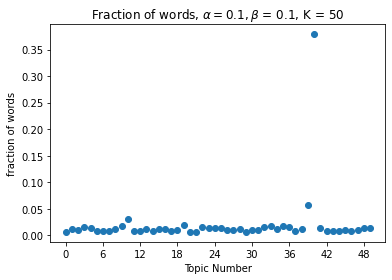

0              1           2            3   \
Topic 9  Raw           alex        mystery      turner        smith   
         Rel     captivated        lincoln    acquaint   conducting   
         RelRaw        alex         turner     lincoln     ackerman   
Topic 19 Raw        science           race  scientific      readers   
         Rel         tribes          reich   ramblings  antoinnette   
         RelRaw     gaskell        dickens     studies   scientific   
Topic 10 Raw            war        america    american        world   
         Rel      vaudville      terrorism         bin        laden   
         RelRaw       clark   infiltration    conflict    strategic   
Topic 39 Raw           book       students       great          use   
         Rel          kelby  instructional     devotes   deservedly   
         RelRaw      useful         design   exercises     students   
Topic 40 Raw           book           read        like        story   
         Rel         astral          story        mets       helped   
         RelRaw       story           read       years         love   

                        4           5             6          7   \
Topic 9  Raw          case         san        wilson     estate   
         Rel        amelia    sandbank         rider   physique   
         RelRaw        san     beatles         smith      cross   
Topic 19 Raw       studies     gaskell       dickens     modern   
         Rel       stalins  tyrannical  predecessors  persuaded   
         RelRaw  daughters       gould        groups    warming   
Topic 10 Raw       country   political           mr.       role   
         Rel       stinger    missiles        bergen  unnerving   
         RelRaw        war        bush        forces    america   
Topic 39 Raw         books    examples          work     useful   
         Rel        evolve   available     tutorials  purchased   
         RelRaw    authors    examples       edition       text   
Topic 40 Raw          time        life         great       good   
         Rel       compose      battle            st   surround   
         RelRaw       like        time       written      think   

                            8               9            10           11  \
Topic 9  Raw         adventure         beatles        knows      lincoln   
         Rel            turner         rinaldi   homeschool     nazareth   
         RelRaw         estate         missing      mystery         mary   
Topic 19 Raw             brain          social        steve       review   
         Rel               ddt         hazards     silicone       breast   
         RelRaw           race           brain      science       global   
Topic 10 Raw          military        conflict        power      society   
         Rel     egyptian-born  middle-eastern  afghanistan   terrorists   
         RelRaw       military        decision        media    political   
Topic 39 Raw       information           ideas      authors      edition   
         Rel           delving           marie      unhappy  bookshelves   
         RelRaw          ideas         chapter     problems          use   
Topic 40 Raw           reading          people        books          way   
         Rel           context          valued   discharged     al-qaeda   
         RelRaw            way          people         best         life   

                          12           13             14          15  \
Topic 9  Raw             men         page        missing        mary   
         Rel     discouraged         apps       modeling      builds   
         RelRaw       wilson       center      adventure       steve   
Topic 19 Raw       daughters         ways          gould      groups   
         Rel        implants  fearmongers      citations    rulebook   
         RelRaw        steve       mental        readers      modern   
Topic 10 Raw           clark        south          media        bush   
         Rel       ter

,Document Number,Dominant Topic,Percentage,Words In Dominant Topic
319,319,40.0,1.000000,"[loved, book, written, funny, relate, author, observations, storyline, wait, book]"
507,507,40.0,1.000000,"[bought, friend, school, said, helped]"
540,540,40.0,1.000000,"[excellent, book, informative, interesting, books, read, life]"
29,29,40.0,0.928571,"[great, way, save, space, wonderful, books, love, find, paperback, great, nora, roberts, stories]"
20,20,39.0,0.920000,"[book, good, quick, easy, understand, guide, illustrator, quick, guide, people, know, adobe, photoshop, reference, tools, helpful, tutorials, stra..."
264,264,39.0,0.916031,"[outline, covers, applied, mathematics, upper, level, undergraduate, graduate, engineers, need, know, solve, problems, great, reference, scope, br..."
182,182,40.0,0.909091,"[fantastic, read, hours, stories, feel, like, written, book, recommend, party]"
233,233,40.0,0.909091,"[bad, way, got, better, cool, book, lot, things, people, think]"
270,270,40.0,0.909091,"[book, helped, understand, things, going, cope, hard, time, living, daughter, book, makes, easier, quick, fix, it...but, book, ways, feeling, deal..."
517,517,40.0,0.900000,"[read, book, bought, right, published, year, ago, finally, writing, year, gone, happened, think, book, books, read, great, book]"





Case 4, α = 0.01, β = 0.01, K = 50




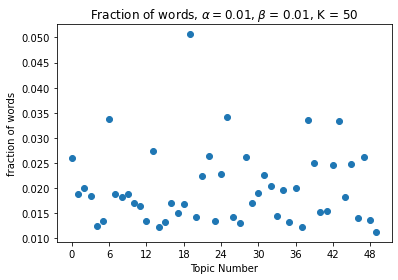

0           1            2                       3   \
Topic 43 Raw           book        read      reading                   found   
         Rel     dispensing      abrupt       below]                   typos   
         RelRaw     husband       pages       mother                 example   
Topic 38 Raw           book        best         like                   great   
         Rel      off-field     diehard  meaningless                    asna   
         RelRaw       needs         job         easy                   gives   
Topic 6  Raw           book        work        great                     use   
         Rel      photoshop    channels      lightly                 devotes   
         RelRaw    position      useful      section                   write   
Topic 25 Raw           book         war        world                    john   
         Rel            ceo  imperative       tribes               countries   
         RelRaw    military    conflict          war                 country   
Topic 19 Raw           book        read      reading                   books   
         Rel      mr.magnus      astral  whillingham  carry-on-to-the-heaven   
         RelRaw     subject    problems      stories                     far   

                         4           5             6               7   \
Topic 43 Raw          pages        time           end           think   
         Rel        closure       brave       samurai          stills   
         RelRaw  definitely      having           end           found   
Topic 38 Raw            job       story         needs          people   
         Rel      reading.a  tangential  stupefyingly       reiterate   
         RelRaw       style        home    understand            best   
Topic 6  Raw        writing      useful   information        students   
         Rel       designed       gaudi  uninterested      chronology   
         RelRaw    examples         buy      students             use   
Topic 25 Raw       american     america       country         history   
         Rel          storm       galba      acquaint  considerations   
         RelRaw     america  government      american            john   
Topic 19 Raw           good   recommend         great            time   
         Rel        exclude        ice'       seaward         sisters   
         RelRaw       makes       learn        better       recommend   

                          8              9              10         11  \
Topic 43 Raw          little         people        example  recommend   
         Rel        admiring     decorating        display    ceiling   
         RelRaw          bit           home          going    reading   
Topic 38 Raw            work        writing           love       easy   
         Rel       dependent         pagels      ambitions  visualize   
         RelRaw         help        writing           love       like   
Topic 6  Raw        examples          works          write    written   
         Rel      upbringing         priced          adobe         cs   
         RelRaw  information          works           work    writing   
Topic 25 Raw      government            mr.  understanding      today   
         Rel          bosnia      holbrooke        supreme       nato   
         RelRaw        today  understanding            mr.      world   
Topic 19 Raw         subject          makes        stories     better   
         Rel         therapy        lead-up     convention   coverage   
         RelRaw  interesting           read          think    reading   

                           12         13                14          15  \
Topic 43 Raw           mother       find           husband      having   
         Rel         organize       fire          doomsday   persuaded   
         RelRaw         think     little         recommend        find   
Topic 38 Raw          reading      gives              help        read   
         Rel     self-control  confi

,Document Number,Dominant Topic,Percentage,Words In Dominant Topic
9,9,6.0,1.000000,"[book, lot, useful, information, setting, running, small, corporations]"
288,288,20.0,1.000000,"[book, arrives, time, good, quality, price, considered, high]"
187,187,22.0,1.000000,"[great, read, short, fast, moving, intro, dirk, pitt, read, series, should.]"
429,429,6.0,1.000000,"[case, book, buy, book, want, buy, long, questions, answer]"
15,15,9.0,1.000000,"[courtney, lied, courtney, addict, stoned, real, evidence, sell, theory, murdered, kurt, aspiring, write, national, inquirer]"
141,141,6.0,1.000000,"[found, book, helpful, walking, process]"
159,159,7.0,1.000000,"[pathetic, title, brilliant, book, wonder, clown, named, harrison]"
471,471,45.0,1.000000,"[amazing, wonderful, book, buy, child, know]"
441,441,19.0,0.909091,"[wish, submitted, favorable, review, book, unfortunately, long-winded, content, tedious, read]"
182,182,19.0,0.909091,"[fantastic, read, hours, identify, stories, like, written, book, recommend, party]"


In [ ]:
# Results
topTopicsSize = 5
iCase = 0
for iTopicList in range(len(numTopicsList)):
    for iParameterList in range(len(parameterList)):
        numTopics = numTopicsList[iTopicList]
        dirParameter = parameterList[iParameterList][0]
        topicParameter = parameterList[iParameterList][1]

        print("Case %d, \u03B1 = %.2f, \u03B2 = %.2f, K = %d\n\n" % (iCase + 1, topicParameter, dirParameter, numTopics))

        # Result part - 1. Plots
        sumWordsinToken = sumWordsinTokenResultsT1[iCase].copy()
        figureNum += 1
        ax = plt.figure(figureNum).gca()
        plt.scatter(np.arange(0, numTopics), sumWordsinToken / maxTokens)
        plt.xlabel("Topic Number")
        plt.ylabel("fraction of words")
        plt.title(r"Fraction of words, $\alpha = {}, \beta$ = {}, K = {}".format(str(topicParameter), str(dirParameter),
                                                                                 str(numTopics)))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show()

        # Result part - 2
        topicWordRelationByRawCount = list()
        topicWordRelationByRelativeCount = list()
        topicWordRelationByRelInMaxRaw = list()
        for iTopic in range(numTopics):
            topicWordRelationByRawCount.append(Counter())
            topicWordRelationByRelInMaxRaw.append(Counter())

        for iNumber, iWord in enumerate(books.listOfWords):
            topicWordRelationByRawCount[wordTopicResultsT1[iCase][iNumber]][iWord] += 1

        for iTopic in range(numTopics):
            topicWordRelationByRelativeCount.append(topicWordRelationByRawCount[iTopic].copy())

        for iTopic in range(numTopics):
            for iWord in topicWordRelationByRawCount[iTopic].keys():
                temp = topicWordRelationByRawCount[iTopic][iWord]
                topicWordRelationByRelativeCount[iTopic][iWord] = temp / books.bagOfWords[
                    iWord]

        for iTopic in range(numTopics):
            tempDict = [topicWordRelationByRawCount[iTopic], topicWordRelationByRelativeCount[iTopic]]
            for iWord in topicWordRelationByRawCount[iTopic].keys():
                topicWordRelationByRelInMaxRaw[iTopic][iWord] = tuple(i[iWord] for i in tempDict)

        backupRel = list()
        for iTopic in range(numTopics):
            backupRel.append(topicWordRelationByRelativeCount[iTopic].copy())

        for iTopic in range(numTopics):
            topicWordRelationByRawCount[iTopic] = sorted(topicWordRelationByRawCount[iTopic].items(),
                                                         key=lambda x: x[1],
                                                         reverse=True)
            topicWordRelationByRelativeCount[iTopic] = sorted(topicWordRelationByRelativeCount[iTopic].items(),
                                                              key=lambda x: x[1], reverse=True)
            topicWordRelationByRelInMaxRaw[iTopic] = sorted(topicWordRelationByRelInMaxRaw[iTopic].items(),
                                                            key=lambda x: x[1][0], reverse=True)

        maxWordsCanBePrinted = list()
        for iMax in range(numTopics):
            maxWordsCanBePrinted.append(len(topicWordRelationByRawCount[iMax]))

        numWordsToPrint = list()
        for iMin in range(numTopics):
            numWordsToPrint.append(min(maxWordsCanBePrinted[iMin], desiredWordsToBePrinted))
            topicWordRelationByRelInMaxRaw[iMin] = topicWordRelationByRelInMaxRaw[iMin][:numWordsToPrint[iMin]]
            topicWordRelationByRelInMaxRaw[iMin] = sorted(topicWordRelationByRelInMaxRaw[iMin],
                                                          key=lambda x: x[1][1], reverse=True)

        uniqueWordsinToken = [len(topicWordRelationByRelativeCount[iTopic]) for iTopic in range(numTopics)]
        uniqueWordsinToken = np.array(uniqueWordsinToken)

        topTopics = sumWordsinToken.argsort()[numTopics - topTopicsSize:]
        listHeader = ["removeMe"]
        for i in range(len(topTopics)):
            listHeader = listHeader + ["Topic {}".format(topTopics[i])]
        listHeader.pop(0)
        colHeaders = pd.MultiIndex.from_product([listHeader, ['Raw', 'Rel', 'RelRaw']])
        resultTopicDF = pd.DataFrame()
        # for iDFRow in range(min(numWordsToPrint)): # For all topics
        for iDFRow in range(desiredWordsToBePrinted):
            tempRow = list()
            for iDFCell in range(len(topTopics)):
                try:
                    tempRow.append(topicWordRelationByRawCount[topTopics[iDFCell]][iDFRow][0])
                except:
                    tempRow.append("NA")
                try:
                    tempRow.append(topicWordRelationByRelativeCount[topTopics[iDFCell]][iDFRow][0])
                except:
                    tempRow.append("NA")
                try:
                    tempRow.append(topicWordRelationByRelInMaxRaw[topTopics[iDFCell]][iDFRow][0])
                except:
                    tempRow.append("NA")
            tempDF = pd.DataFrame([tempRow])
            if len(tempRow) > 0:
                resultTopicDF = resultTopicDF.append(tempDF, ignore_index=True)
            tempRow.clear()
        resultTopicDF.columns = colHeaders
        display(resultTopicDF.head(desiredWordsToBePrinted).transpose())

        print("\n\n")

        # Result part - 3. Works fine(Hopefully)
        topicCount = list()
        topicCountPerc = list()
        maxTopicNumPerc = np.zeros((numDocs, 2), dtype=float)
        wordsInMaxTopic = list()
        iPosition = 0
        jPosition = 0
        for iDoc in range(numDocs):
            topicCountPerc.append(np.zeros(numTopics, dtype=float))
            topicCount.append(np.zeros(numTopics, dtype=int))
            wordsInMaxTopic.append(list())

            for iWord in range(jPosition, jPosition + books.docLen[iDoc]):
                topicCount[iDoc][wordTopicResultsT1[iCase][iWord]] += 1
            jPosition += books.docLen[iDoc]
            topicCountPerc[iDoc] = topicCount[iDoc] / books.docLen[iDoc]

            maxTopicNumPerc[iDoc][0] = int(topicCount[iDoc].argmax())
            maxTopicNumPerc[iDoc][1] = max(topicCountPerc[iDoc])

            for iWord in range(iPosition, iPosition + books.docLen[iDoc]):
                if wordTopicResultsT1[iCase][iWord] == maxTopicNumPerc[iDoc][0]:
                    wordsInMaxTopic[iDoc].append(books.listOfWords[iWord])
            iPosition += books.docLen[iDoc]

        documentTopicsDF = pd.DataFrame()

        documentTopicsDF.insert(0, "Document Number", np.arange(0, numDocs, 1))
        documentTopicsDF.insert(1, "Dominant Topic", maxTopicNumPerc[:, 0])
        documentTopicsDF.insert(2, "Percentage", maxTopicNumPerc[:, 1])
        documentTopicsDF.insert(3, "Words In Dominant Topic", wordsInMaxTopic)
        documentTopicsDF = documentTopicsDF.sort_values("Percentage", ascending=False)
        pd.set_option('display.max_colwidth', 150)
        documentTopicsDF.style.hide_index()
        display(documentTopicsDF.head(15))
        pd.set_option('display.max_colwidth', colWidth)
        
        print("\n\n")
        iCase += 1


# Inferences

The key inferences are listed here:


1.   The plots represent that a good fraction of words end up in fewer topics. However, this essentially means that the raw count in few topics is higher than other topics, however, the number of distinct words can have a differnt distribution.
2.   Some of the topics forms a good cluster of words that closely resemble each other. 
3.   The doucment dominant topic table plays a good role in finding the key words under a particular topic. 

One examples explaining these phenomenon is:
In case 4, form the first table, the dominant topics contains words that cosely relates to 

Topic | Meaning | Relation
--- | --- | ---
43 | Family | **
38 | Worklife | *
6 | Academic docs | ***
25 | Terrorism and war | ****
19 | Generic | *

Similarly, in case 4 second table, we can find an interesting observation that the documnet 15 contains good number of words related to topic Drug and ends up in topic 9. Topic 9 isn't very dominant in terms of raw frequency but we may infer that it contains words that resembles to drugs. 

Lastly, from the figures, it is quite clear that the distribution of words in topic is affected by changing the parameters from 0.1 to 0.01. It is noted that there is high variance in fraction of words in case of parameters 0.1 as compared to 0.01.
